# Huismans-Like model

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /home/romain/Projects/Project_UWGeodynamics/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


## Working with units


In [2]:
u = GEO.UnitRegistry

In [3]:
half_rate = 2.5 * u.centimeter / u.year
model_length = 1200. * u.kilometer
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

In [4]:
Model = GEO.Model(elementRes=(128, 32), 
                  minCoord=(-600 * u.kilometer, -600. * u.kilometer), 
                  maxCoord=(600. * u.kilometer, 0. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
from UWGeodynamics import remesh
import numpy as np
  
xnodes = GEO.nd(np.array([-600, -120, 0.]) * u.km)
ynodes = GEO.nd(np.array([-600, 600]) * u.km)

remesh(Model.mesh, xnodes, np.array([2, 30]), ynodes, np.array([128]))


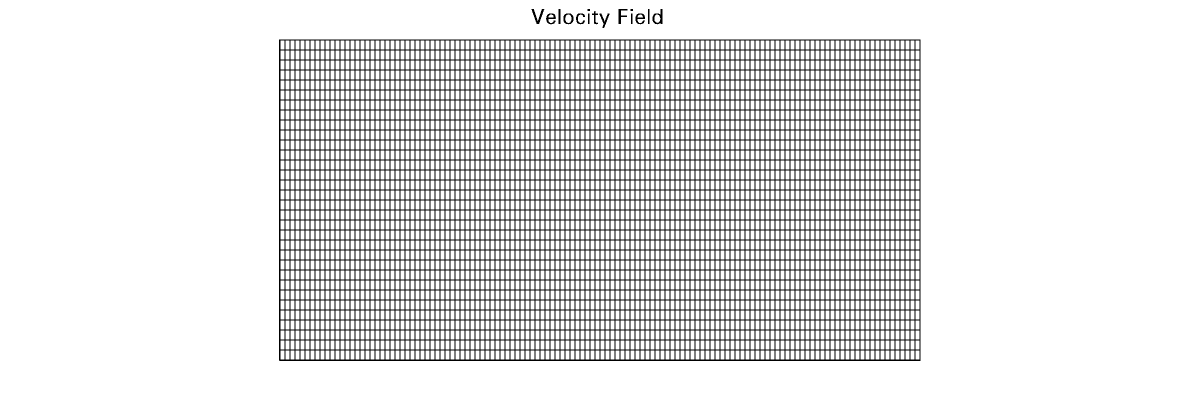

In [6]:
Fig = vis.Figure(figsize=(1200,400), title="Velocity Field", quality=2)
Fig.Mesh(Model.mesh)
Fig.show()

In [7]:
Model.outputDir = "Huismans"

## Materials


In [8]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

In [9]:
crust = Model.add_material(name="Crust", shape=GEO.shapes.Layer(top=Model.top, bottom=-35.0 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer(top=crust.bottom, bottom=-120.0 * u.kilometer))
mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=mantleLithosphere.bottom, bottom=Model.bottom))

seedShape = GEO.shapes.Box(minX=-6.*u.km, maxX=6.*u.km, bottom=-45 * u.km, top=-35 * u.km)
seed = Model.add_material(name="Seed", shape=seedShape)

In [10]:
crust.density = 2620. * u.kilogram / u.metre**3
mantleLithosphere.density = 3370. * u.kilogram / u.metre**3
mantle.density = 3370. * u.kilogram / u.metre**3
seed.density = 3370. * u.kilogram / u.metre**3

In [11]:
crust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3

## Rheologies


In [12]:
rh = GEO.ViscousCreepRegistry()

In [13]:
Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

crust.viscosity              = 1e23 * u.pascal * u.second
mantleLithosphere.viscosity  = 1e22 * u.pascal * u.second
mantle.viscosity             = 1e18 * u.pascal * u.second
seed.viscosity               = 1e22 * u.pascal * u.second

In [14]:
#pl = GEO.PlasticityRegistry()

In [15]:
#crust.plasticity              = pl.Huismans_et_al_2011_Crust
#mantleLithosphere.plasticity  = pl.Huismans_et_al_2011_Crust

In [16]:
#weakSeedPl = pl.Huismans_et_al_2011_Crust
#weakSeedPl.frictionCoefficient = 0.02

#seed.plasticity = weakSeedPl

## Thermal Boundary conditions

In [17]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK)

## Mechanical Boundary conditions

In [18]:
from UWGeodynamics import Balanced_InflowOutflow

In [19]:
Model.set_velocityBCs(left=[Balanced_InflowOutflow(-2.5 * u.centimeter / u.year, Model.top, -140 * u.km, -180 * u.km), 0.],
                      right=[Balanced_InflowOutflow(2.5 * u.centimeter / u.year, Model.top, -140 * u.km, -180 * u.km), 0.],
                      bottom=(None, 0.),
                      top=(None, None),
                      order_wall_conditions=["top", "bottom", "left", "right"])

In [20]:
#Model.freeSurface = True


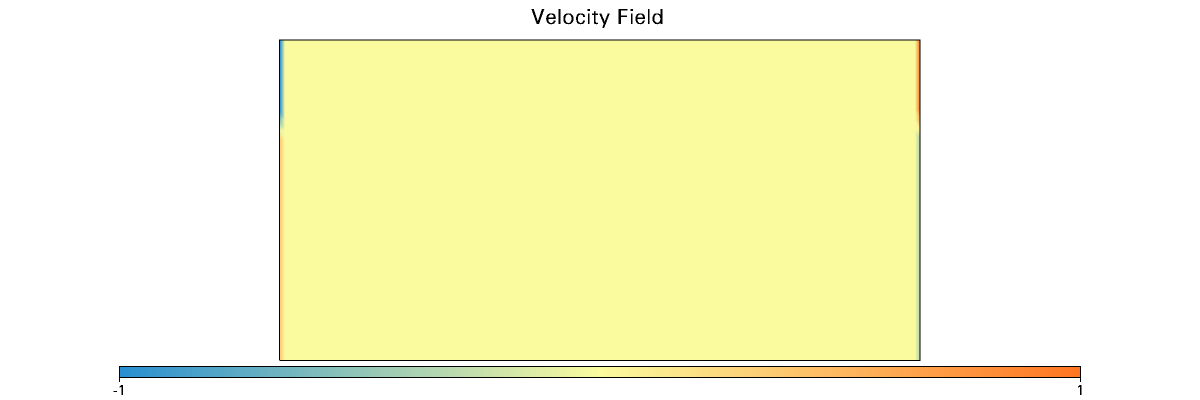

In [21]:
Fig = vis.Figure(figsize=(1200,400), title="Velocity Field", quality=2)
Fig.Surface(Model.mesh, Model.velocityField[0])
Fig.show()


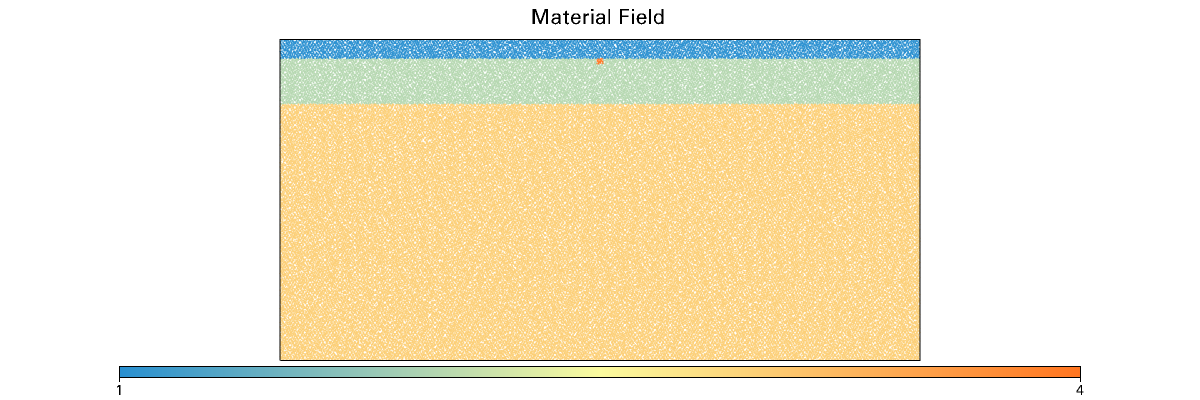

In [22]:
Fig = vis.Figure(figsize=(1200,400), title="Material Field", quality=2)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()


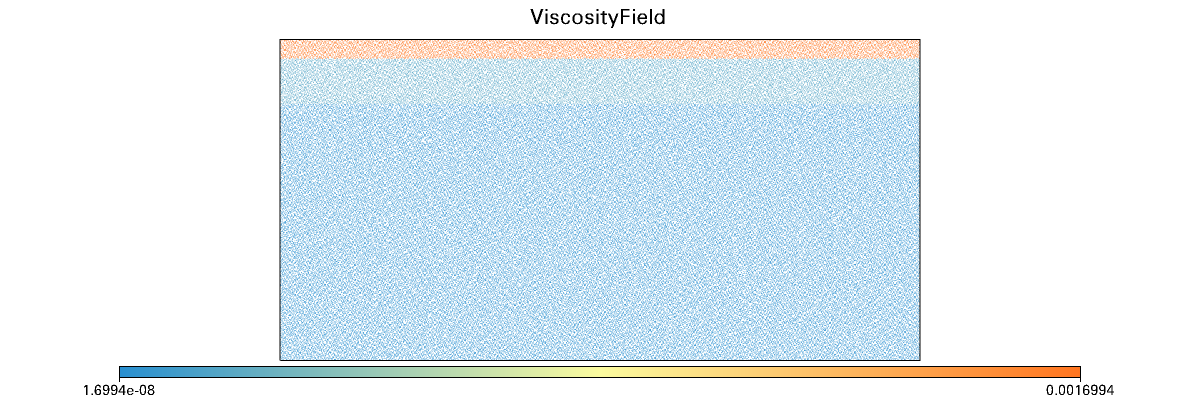

In [23]:
Fig = vis.Figure(figsize=(1200,400), title="ViscosityField", quality=2)
Fig.Points(Model.swarm, Model.viscosityField)
Fig.show()

In [24]:
Model.init_model(temperature="steady-state", pressure="lithostatic")


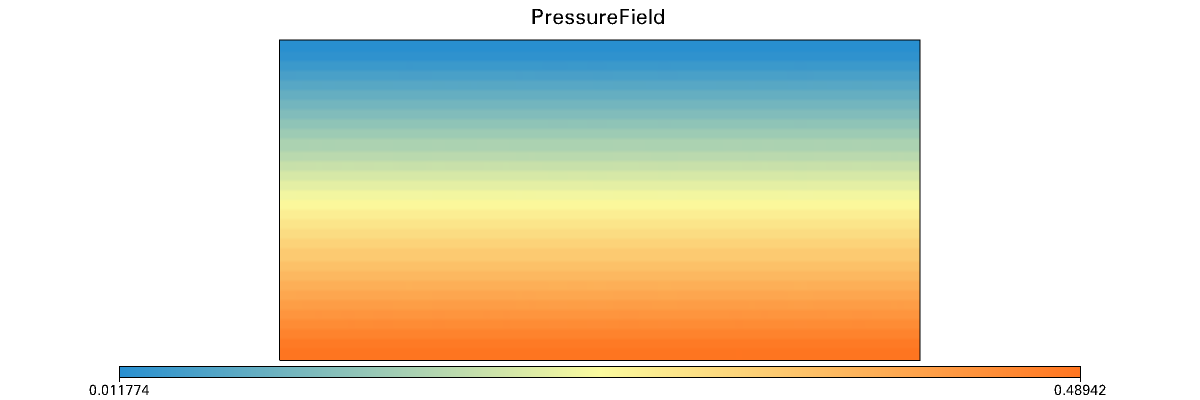

In [25]:
Fig = vis.Figure(figsize=(1200,400), title="PressureField", quality=2)
Fig.Surface(Model.mesh.subMesh, Model.pressureField)
Fig.show()


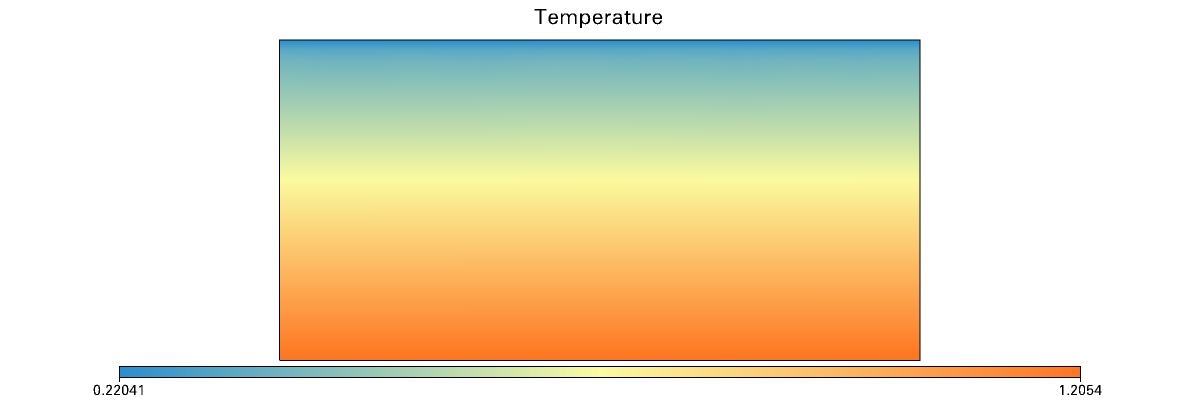

In [26]:
Fig = vis.Figure(figsize=(1200,400), title="Temperature", quality=2)
Fig.Surface(Model.mesh, Model.temperature)
Fig.show()

In [27]:
# Model.solver.set_inner_method("mumps")
# Model.solver.set_penalty(1e6)
# GEO.rcParams["initial.nonlinear.tolerance"] = 1e-2

In [28]:
Model.run_for(nstep=1, checkpoint_interval=1)

Running with UWGeodynamics version 2.10.5
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type fgmres -A11_ksp_rtol 1e-06 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05
Step:     1 Model Time: 0.0 second dt: 0.0 second (2021-03-23 11:07:01)


1

/home/romain/Projects/Project_UWGeodynamics/virtualenv/lib/python3.9/site-packages/underworld/scaling/_scaling.py:187: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  tempVar.data[...] = (value.data[...] * factor).to(units)



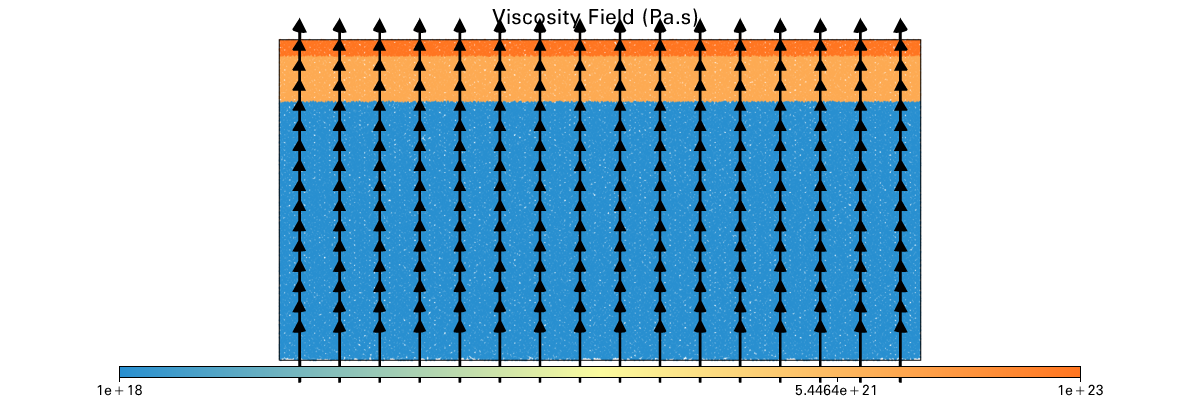

In [29]:
Fig = vis.Figure(figsize=(1200,400), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()

In [30]:
Model.velocityField.data[Model.left_wall]

array([[  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  3.61702128e-01,   2.16215516e+17],
       [  

In [31]:
Model.velocityField.data[Model.right_wall]

array([[ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -3.61702128e-01,   2.16215516e+17],
       [ -